# CIFAR10

Notebook to compare models for RGB object classification (CIFAR10).

Use `scripts/simulate_examples.py` to visualize embeddings and learned PSFs.

In [3]:
import numpy as np
import pathlib as plib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from lenslessclass.datasets import Augmented
from lenslessclass.models import SLMMultiClassLogistic
import json
from pprint import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from waveprop.devices import slm_dict, sensor_dict
import torchvision.datasets as dset
import matplotlib
import os
from lenslessclass.vgg import VGG, cfg
import random
from lenslessclass.model_dict import model_dict


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)
linewidth = 3
markersize = 200

MODEL_DIR = "../models/cifar10"


models = model_dict["CIFAR10"]


markers_dict = {
    "Lens": "o",
    "Coded aperture": "s",
    "Diffuser": "X",
    "Fixed mask (m)": "^",
    "Fixed mask (s)": "v",
    "Learned mask": "D",
}
color_dict = {
    "Lens": "darkorange",
    "Coded aperture": "red",
    "Diffuser": "deeppink",
    "Fixed mask (m)": "purple",
    "Fixed mask (s)": "blue",
    "Learned mask": "g",
}

markers = ["o", "s", "D", "P", "X", "v",  "<", ">", "D", ".", "1", "2", "3", "4", "8"]
linestyles = ["solid", "dotted", "dashed", "dashdot", (0, (3, 1, 1, 1, 1, 1))]

# accuracy curves

27x36 - best accuracy in 50 epochs : 0.513
13x17 - best accuracy in 50 epochs : 0.49
6x8 - best accuracy in 50 epochs : 0.447
3x4 - best accuracy in 50 epochs : 0.41
no saved plot


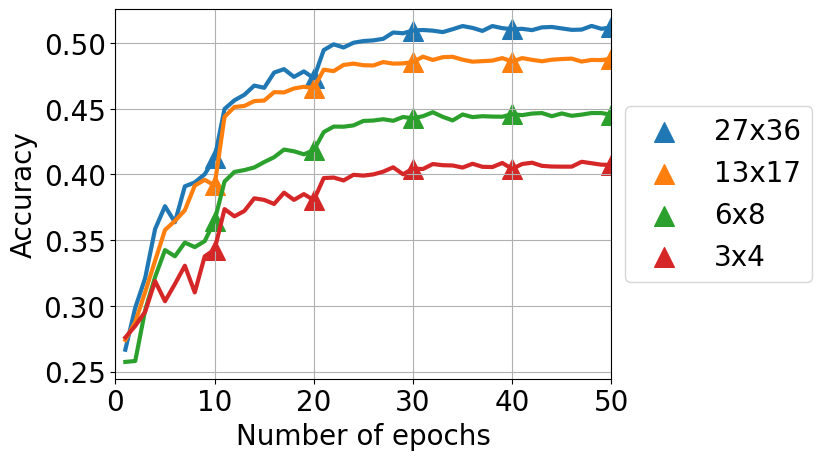

In [4]:
MAX_EPOCH = 50
plot_train = False
every = 10


cam_filt = None
cam_filt = ["Fixed mask (m)"]
arch_filt = None
arch_filt = ["VGG11"]
dim_filt = None
# dim_filt = ["6x8"]


ax = plt.subplot(111)
for cam in models.keys():
    if cam_filt is not None and cam not in cam_filt:
        continue
    for arch in models[cam].keys():
        if arch_filt is not None and arch not in arch_filt:
            continue
        for dim in models[cam][arch].keys():
            if dim_filt is not None and dim not in dim_filt:
                continue
            _label = []
            if cam_filt is None or len(cam_filt) > 1:
                _label += [cam]
            if arch_filt is None or len(arch_filt) > 1:
                _label += [arch]
            if dim_filt is None or len(dim_filt) > 1:
                _label += [dim]

            _label = ", ".join(_label)
            model_path = MODEL_DIR / plib.Path(models[cam][arch][dim])
            
            test_acc_fp = str(plib.Path(model_path) / "test_acc.npy")
            if os.path.exists(test_acc_fp):
                test_acc = np.load(test_acc_fp)
                n_epoch = np.arange(len(test_acc)) + 1
                print(f"{_label} - best accuracy in {min(MAX_EPOCH, len(test_acc))} epochs : {round(np.max(test_acc[:MAX_EPOCH]), 3)}")
                line, = plt.plot(n_epoch,  test_acc, linewidth=linewidth, linestyle="-")
                ax.scatter(n_epoch[every-1::every], test_acc[every-1::every], marker=markers_dict[cam], s=markersize, c=line.get_color(), label=_label)
            else:
                print(f"{_label} - {test_acc_fp} does not exist")

            if plot_train:
                train_acc_fp = str(plib.Path(model_path) / "train_acc.npy")
                if os.path.exists(train_acc_fp):
                    train_acc = np.load(train_acc_fp)
                    n_epoch = np.arange(len(train_acc)) + 1
                    print(f"{_label} - best *train* accuracy in {min(MAX_EPOCH, len(test_acc))} epochs : {round(np.max(train_acc[:MAX_EPOCH]), 3)}")
                    plt.plot(n_epoch,  train_acc, c=line.get_color(), label=_label + ", train", linestyle="--", linewidth=linewidth)
            
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Accuracy")
plt.xlabel("Number of epochs")
plt.xlim([0, MAX_EPOCH]);
plt.grid()

try:
    if len(arch_filt) == 1 and len(dim_filt) == 1:
        fp = f"CIFAR10_{arch_filt[0]}_{dim_filt[0]}.png"
        plt.savefig(fp, bbox_inches='tight')
        print("plot saved to ", fp)
except:
    print("no saved plot")
            

# confusion matrix

In [5]:
DATA_DIR = "../data"  # to overwrite parent directory in metadata of model

# select model
model_dir = MODEL_DIR / plib.Path(models["Learned mask"]["VGG11"]["27x36"])
# model_dir = MODEL_DIR / plib.Path(models["Fixed mask (s)"]["VGG11"]["27x36"])


f = open(str(model_dir / "metadata.json"))
metadata = json.load(f)
pprint(metadata)

{'aug_pad': 28,
 'batch_size': 32,
 'best_test_acc': 0.6301999688148499,
 'best_test_acc_epoch': 47,
 'dataset': '/home/bezzam/LenslessClassification/data/CIFAR10_no_psf_down8_height0.25_NORM',
 'down_orig': 1.0,
 'mean': [0.1105, 0.1084, 0.1001],
 'min_val': -0.45642295479774475,
 'model': 'SLM_VGG11',
 'model_param': {'cnn_lite': None,
                 'crop_fact': 0.8,
                 'deadspace': True,
                 'device': 'cuda:1',
                 'device_mask_creation': 'cuda:1',
                 'down': 'resize',
                 'dropout': None,
                 'grayscale': False,
                 'hidden': None,
                 'hidden2': None,
                 'input_shape': [3, 380, 507],
                 'kernel_size': 3,
                 'mask2sensor': 0.004,
                 'multi_gpu': True,
                 'n_class': 10,
                 'n_kern': None,
                 'n_slm_mask': 1,
                 'pool': 2,
                 'scene2mask': 0.4,
        

In [6]:
torch.manual_seed(metadata["seed"])
random.seed(metadata["seed"])
np.random.seed(metadata["seed"])


# load model
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("CUDA available, using GPU.")
    device = "cuda"
else:
    device = "cpu"
    print("CUDA not available, using CPU.")

if "SLM" in metadata["model"]:

    sensor_act_fn = None
    sensor_act = metadata["sensor_activation"]
    if sensor_act is not None:
        if sensor_act == "relu":
            sensor_act_fn = nn.ReLU()
        elif sensor_act == "leaky":
            sensor_act_fn = nn.LeakyReLU(float=0.1)
        elif sensor_act == "tanh":
            sensor_act_fn = nn.Tanh()
        else:
            raise ValueError("Not supported activation.")

    metadata["model_param"].update(
        {
            "slm_config": slm_dict[metadata["slm"]],
            "sensor_config": sensor_dict[metadata["sensor"]],
            "sensor_activation": sensor_act_fn,
            "multi_gpu": [0, 1] if metadata["model_param"]["multi_gpu"] else False,
        }
    )
    model = SLMMultiClassLogistic(**metadata["model_param"])
    if use_cuda:
        model = model.to(device)

    # -- load from state dict
    state_dict_fp = str(model_dir / "state_dict.pth")
    model.load_state_dict(torch.load(state_dict_fp))

    # recompute PSF for loaded SLM values
    model.grayscale = False
    model.compute_intensity_psf()

    device = model.device

    
else:

    if "VGG" in metadata["model"]:
        model = VGG(metadata["model"], input_shape=metadata["output_dim"])

    if metadata["model_param"]["multi_gpu"]:
        model = nn.DataParallel(model, device_ids=metadata["model_param"]["multi_gpu"])
        device = "cuda:" + str(int(metadata["model_param"]["multi_gpu"][0]))

    if use_cuda:
        model = model.to(device)

    # -- load from state dict
    state_dict_fp = str(model_dir / "state_dict.pth")
    model.load_state_dict(torch.load(state_dict_fp))

    

CUDA available, using GPU.


In [7]:
print("\nModel's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
slm_vals 	 torch.Size([51, 22])
classifier.module.features.0.weight 	 torch.Size([64, 3, 3, 3])
classifier.module.features.0.bias 	 torch.Size([64])
classifier.module.features.1.weight 	 torch.Size([64])
classifier.module.features.1.bias 	 torch.Size([64])
classifier.module.features.1.running_mean 	 torch.Size([64])
classifier.module.features.1.running_var 	 torch.Size([64])
classifier.module.features.1.num_batches_tracked 	 torch.Size([])
classifier.module.features.4.weight 	 torch.Size([128, 64, 3, 3])
classifier.module.features.4.bias 	 torch.Size([128])
classifier.module.features.5.weight 	 torch.Size([128])
classifier.module.features.5.bias 	 torch.Size([128])
classifier.module.features.5.running_mean 	 torch.Size([128])
classifier.module.features.5.running_var 	 torch.Size([128])
classifier.module.features.5.num_batches_tracked 	 torch.Size([])
classifier.module.features.8.weight 	 torch.Size([256, 128, 3, 3])
classifier.module.features.8.bias 	 torch.Size([2

In [11]:
_path = DATA_DIR / plib.Path(os.path.basename(metadata["dataset"]))
print(_path)


def get_transform(mean, std, outdim):
    trans_list = []
    # resize image to (32, 32) square, easier to work with for CNN arch
    # https://stats.stackexchange.com/questions/240690/non-square-images-for-image-classification
    min_dim = min(outdim)  # taking minimum as edge typically black due to cropping
    trans_list += [transforms.CenterCrop(min_dim), transforms.Resize(32)]
    trans_list += [transforms.ToTensor(), transforms.Normalize(mean, std)]
    return transforms.Compose(trans_list)

# load test set
if "SLM" in metadata["model"]:
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(metadata["mean"], metadata["std"])])
else:
    trans = get_transform(mean=metadata["mean"], std=metadata["std"], outdim=metadata["output_dim"][1:])


test_set = Augmented(path=_path, train=False, transform=trans)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=metadata["batch_size"], shuffle=False
)


print(len(test_set))


../data/CIFAR10_no_psf_down8_height0.25_NORM
10000


In [12]:
# compute accuracy
criterion = nn.CrossEntropyLoss().to(device)

y_pred = []
y_true = []
correct_cnt, running_loss = 0, 0
total_cnt = 0


model.eval()
with torch.no_grad():
    for x, target in test_loader:

        # get inputs
        if use_cuda:
            x, target = x.to(device=device), target.to(device=device)

        if "min_val" in metadata.keys():
            x -= metadata["min_val"]

        # forward, and compute loss
        out = model(x).to(device=device)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        pred_label = pred_label.to(device=device)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()

        # save prediction and true for confusion matrix
        y_pred.extend(pred_label.data.cpu().numpy()) # Save Prediction
        y_true.extend(target.data.cpu().numpy())

acc = (correct_cnt * 1.0 / total_cnt).item()
print("acc: {:.3f}".format(acc))
print('Class distribution: %s' % np.bincount(y_true))

acc: 0.628
Class distribution: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


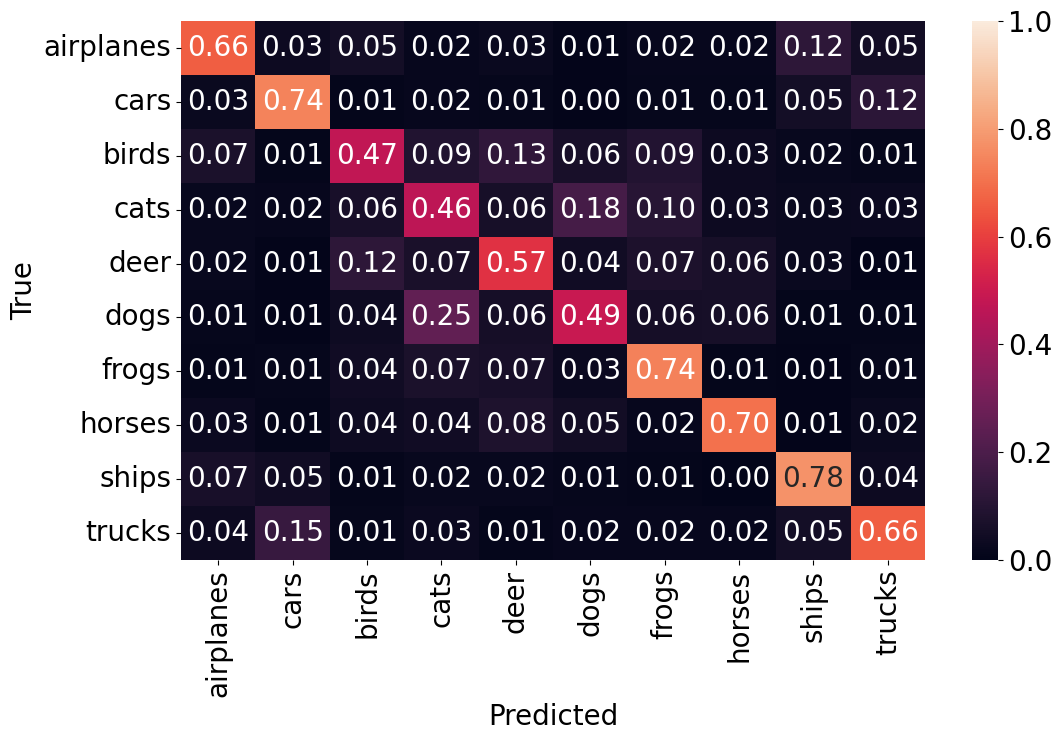

In [13]:
# Build confusion matrix
classes = [
    "airplanes", "cars", "birds", "cats", "deer", "dogs", "frogs", "horses", "ships", "trucks"
]
cf_matrix = confusion_matrix(y_true, y_pred, normalize="true")
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt=".2f", vmin=0, vmax=1)
plt.ylabel("True")
plt.xlabel("Predicted");